In [85]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,  Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

In [86]:
dataset=pd.read_csv("traffic.csv")
data=dataset.copy()
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [87]:
dataset.shape

(48120, 4)

In [88]:
dataset.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [89]:
# convert DateTime in string to DateTime format
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])

# index DateTime
dataset.set_index('DateTime', inplace=True)

dataset.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [90]:
dataset.isnull().sum()

Junction    0
Vehicles    0
ID          0
dtype: int64

In [91]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48120 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Junction  48120 non-null  int64
 1   Vehicles  48120 non-null  int64
 2   ID        48120 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


In [92]:
junc1 = dataset[dataset['Junction']==1]

In [93]:
junc1.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [94]:
junc1.shape

(14592, 3)

<Axes: xlabel='DateTime'>

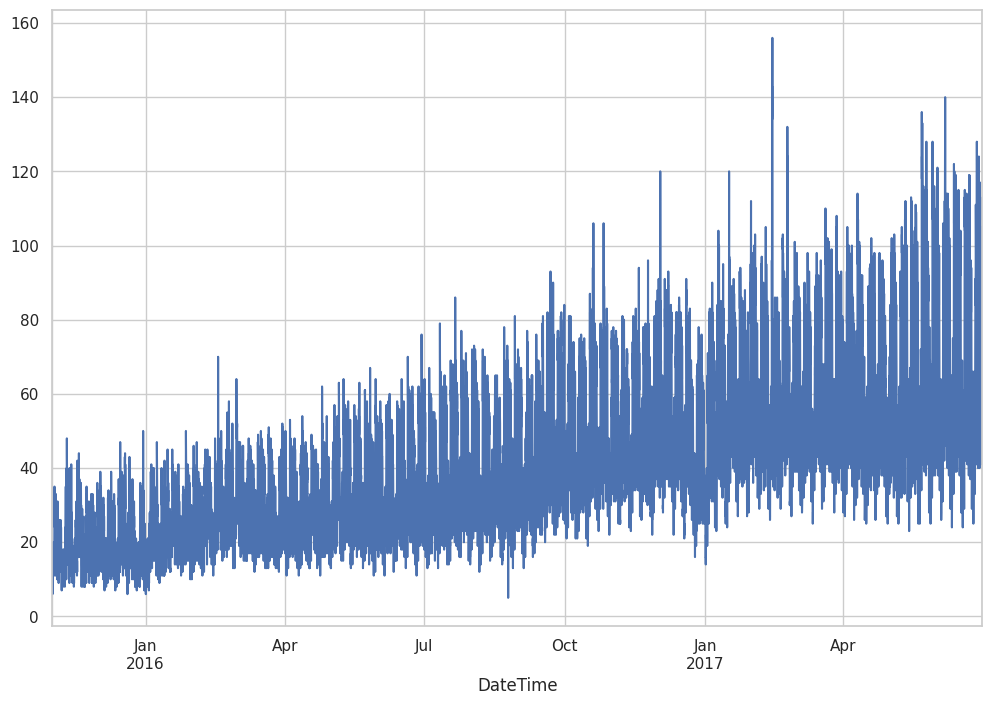

In [95]:
junc1['Vehicles'].plot()

In [96]:
# resample data as daily average

daily_junc1 = junc1.Vehicles.resample('D').mean()

In [97]:
daily_junc1

DateTime
2015-11-01    13.625000
2015-11-02    22.750000
2015-11-03    22.666667
2015-11-04    20.750000
2015-11-05    19.333333
                ...    
2017-06-26    73.916667
2017-06-27    91.125000
2017-06-28    86.666667
2017-06-29    86.916667
2017-06-30    78.458333
Freq: D, Name: Vehicles, Length: 608, dtype: float64

In [98]:
daily_junc1.shape

(608,)

<Axes: xlabel='DateTime'>

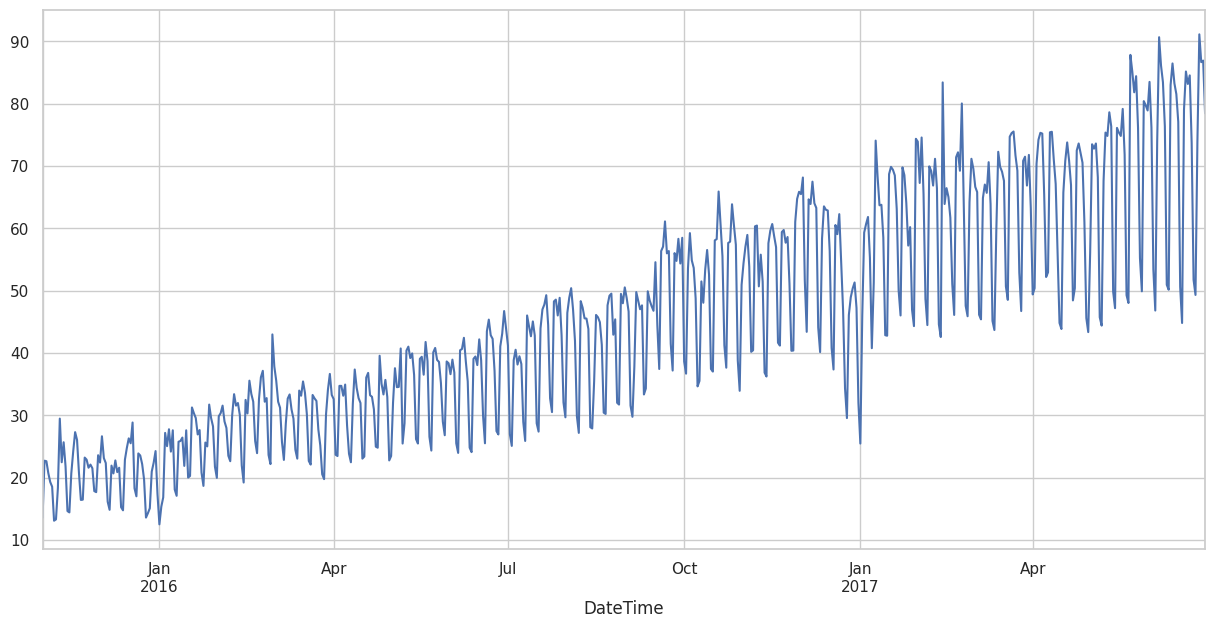

In [99]:
# plot resampled junc 1 data

plt.figure(figsize=(15,7))
daily_junc1.plot()

In [100]:
data.drop(['ID'],axis=1, inplace=True)

data

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9
...,...,...,...
48115,2017-06-30 19:00:00,4,11
48116,2017-06-30 20:00:00,4,30
48117,2017-06-30 21:00:00,4,16
48118,2017-06-30 22:00:00,4,22


In [101]:
# feature engineering

# exploring more features
# year, month, date, days, hour

data['DateTime'] = pd.to_datetime(data['DateTime'])

data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Date_no'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data.DateTime.dt.strftime("%A")
data.head(25)

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday
5,2015-11-01 05:00:00,1,6,2015,11,1,5,Sunday
6,2015-11-01 06:00:00,1,9,2015,11,1,6,Sunday
7,2015-11-01 07:00:00,1,8,2015,11,1,7,Sunday
8,2015-11-01 08:00:00,1,11,2015,11,1,8,Sunday
9,2015-11-01 09:00:00,1,12,2015,11,1,9,Sunday


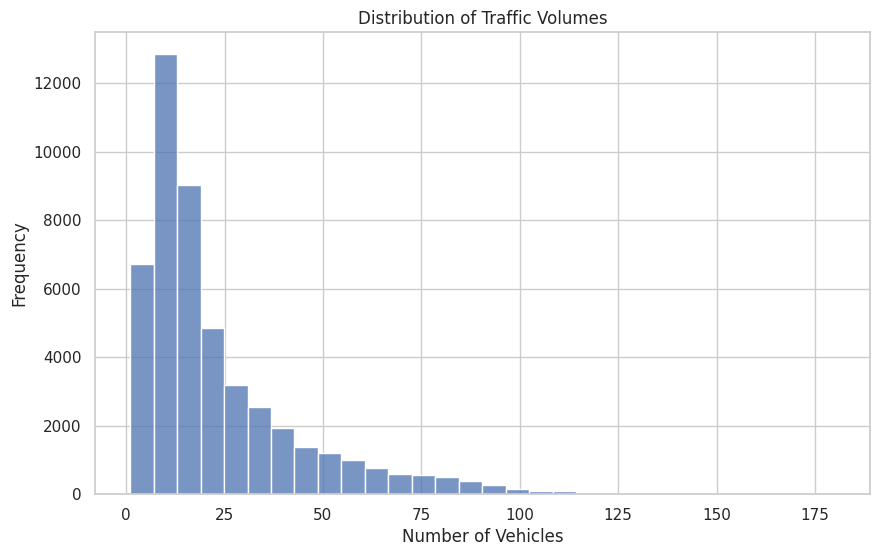

In [102]:
# Set the style of seaborn

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data['Vehicles'], kde=False, bins=30)
plt.title('Distribution of Traffic Volumes')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 0, 'Date')

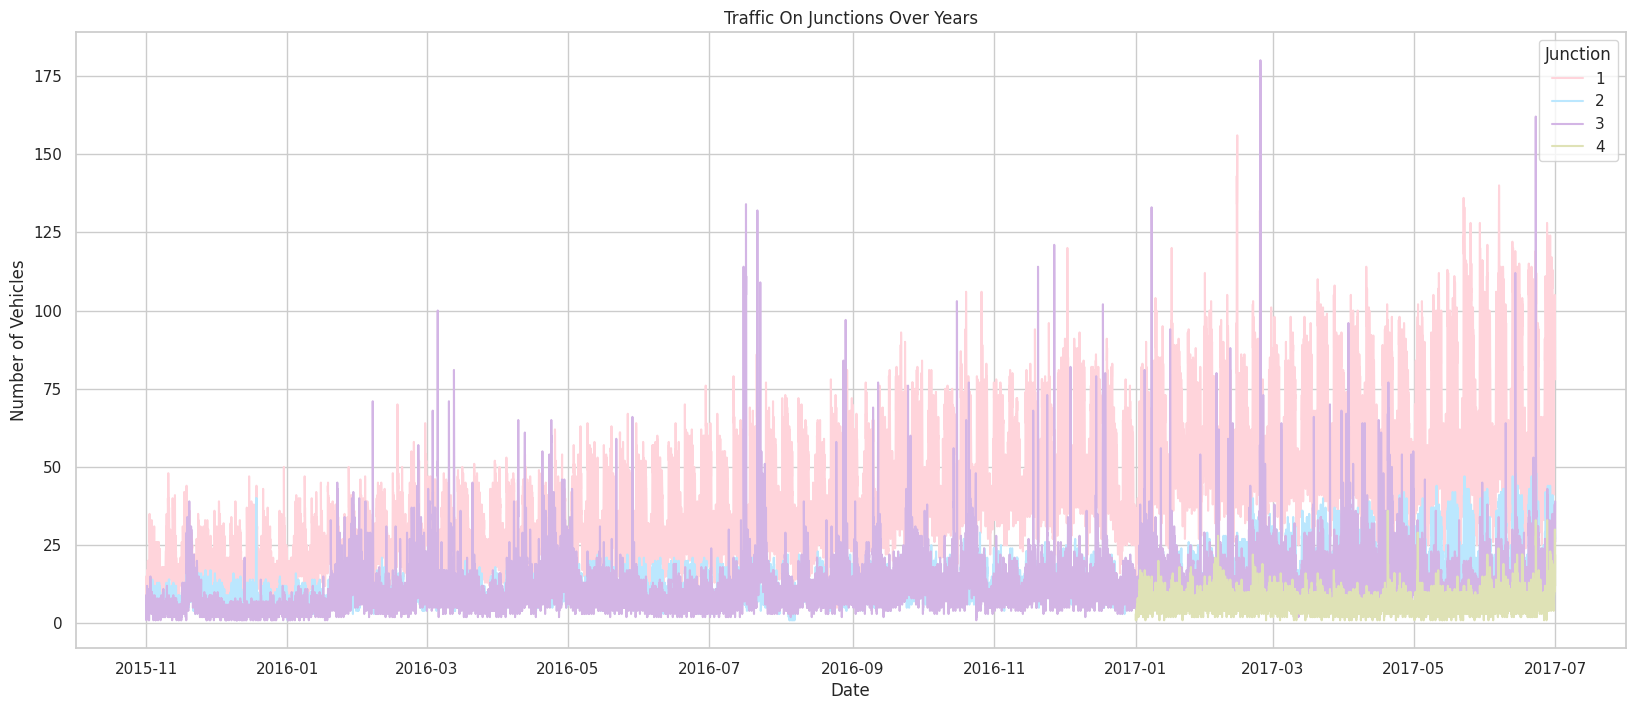

In [103]:
# plot timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]

plt.figure(figsize=(20,8))
Time_series = sns.lineplot(x=data['DateTime'],y="Vehicles",data=data, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

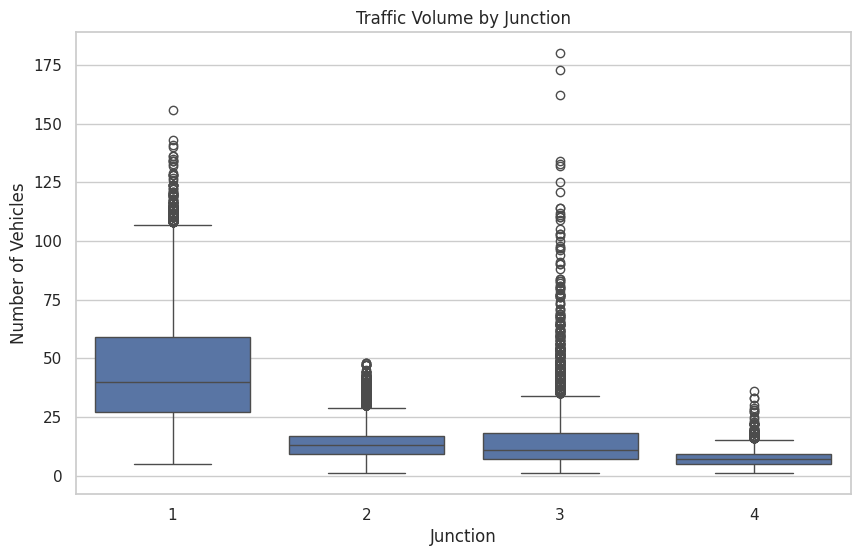

In [104]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=dataset)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

Text(0.5, 0, 'Date')

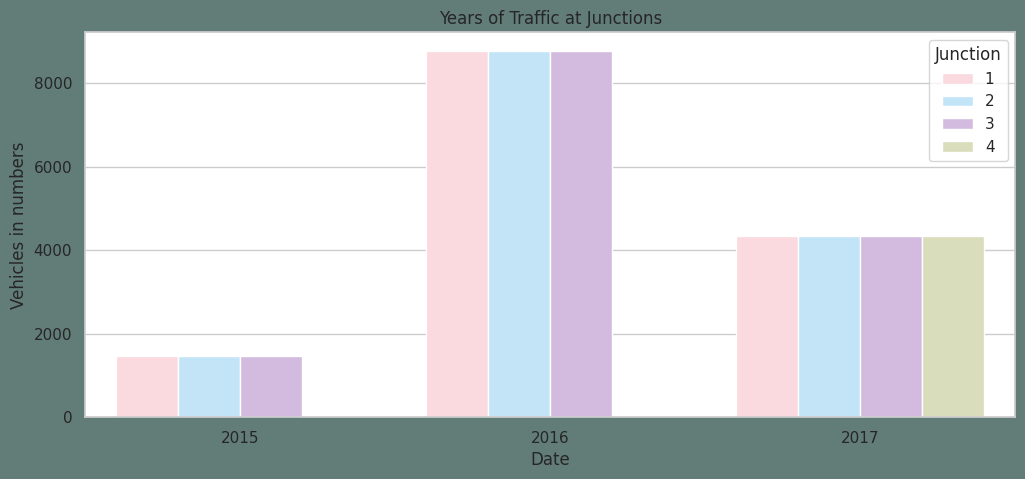

In [105]:
# traffic count on junctions
plt.figure(figsize=(12,5),facecolor="#627D78")
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
count = sns.countplot(data=data, x =data["Year"], hue="Junction", palette=colors)
count.set_title("Years of Traffic at Junctions")
count.set_ylabel("Vehicles in numbers")
count.set_xlabel("Date")

##Time Series Decomposition##
Decompose the traffic volume time series into trend, seasonal, and residual components to better understand underlying patterns

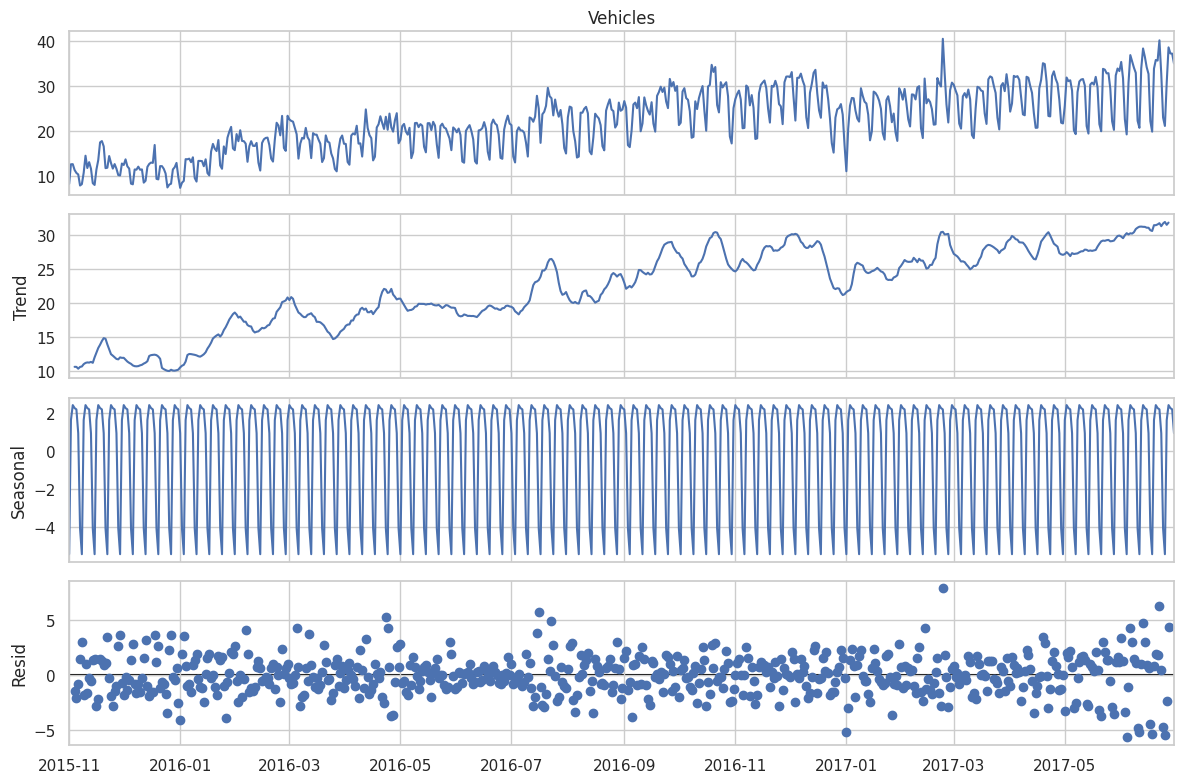

In [106]:
traffic_data = pd.read_csv('traffic.csv')


traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data.set_index('DateTime', inplace=True)

# Resample the data to get daily averages
daily_traffic = traffic_data.resample('D').mean()

# Perform the seasonal decomposition
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)


plt.rcParams['figure.figsize'] = [12, 8]

result.plot()
plt.tight_layout()
plt.show()

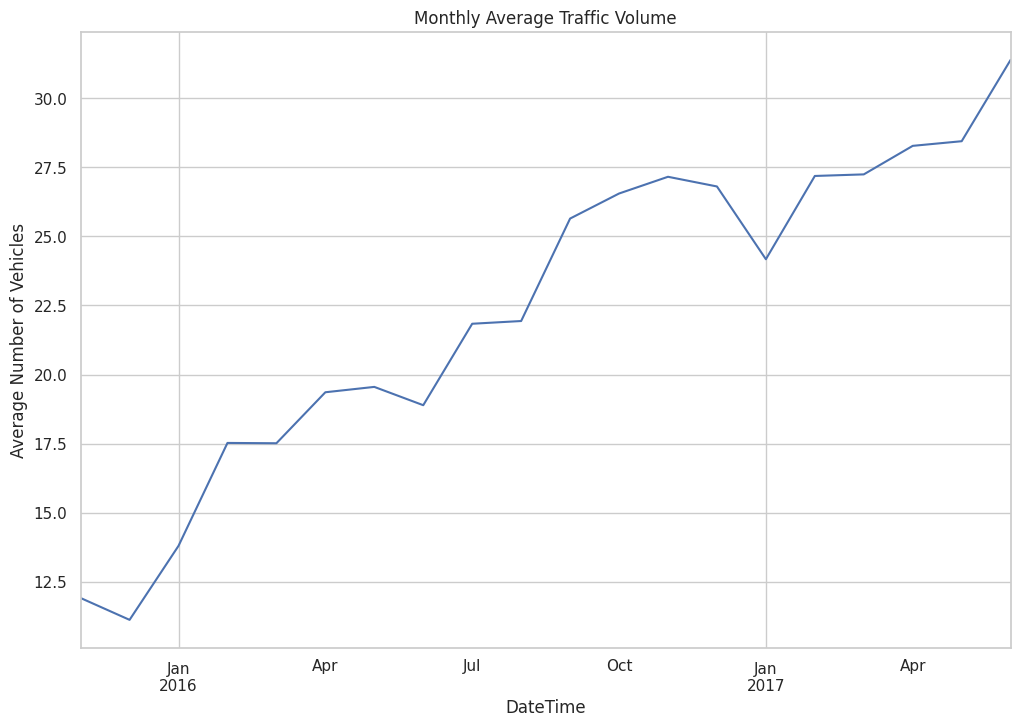

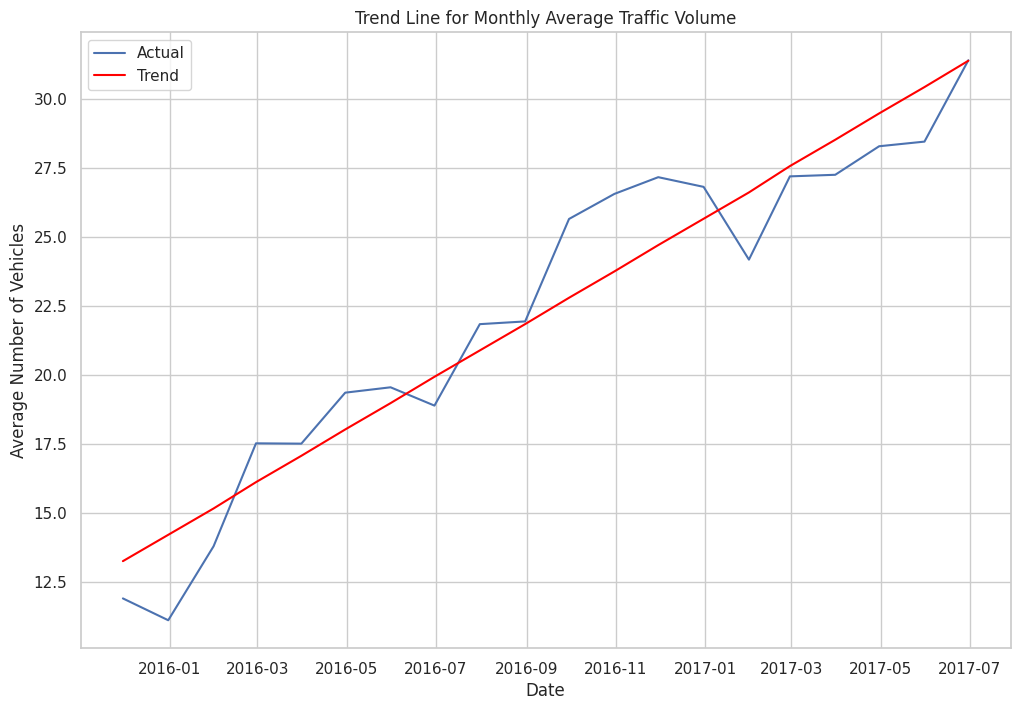

In [107]:
traffic_data = pd.read_csv('traffic.csv')
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Resample the data to get monthly averages
traffic_data.set_index('DateTime', inplace=True)
monthly_traffic = traffic_data.resample('M').mean()

# Plot the monthly traffic volume
monthly_traffic['Vehicles'].plot(title='Monthly Average Traffic Volume')
plt.ylabel('Average Number of Vehicles')
plt.show()

# Linear Regression for Trend Analysis

X = np.arange(len(monthly_traffic)).reshape(-1, 1)  # Time as an independent variable
y = monthly_traffic['Vehicles'].values  # Traffic volume as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the trend
plt.plot(monthly_traffic.index, y, label='Actual')
plt.plot(monthly_traffic.index, trend, label='Trend', color='red')
plt.title('Trend Line for Monthly Average Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.legend()
plt.show()

In [108]:
def adf_check(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# Apply the function on time series data
adf_check(dataset['Vehicles'])

ADF Statistic: -7.518278111935714
p-value: 3.851060199915712e-11
Critical Values:
	1%: -3.430486066940443
	5%: -2.8616001387397922
	10%: -2.566802009871527


In [109]:
traffic_data['Vehicles_diff'] = traffic_data['Vehicles'] - traffic_data['Vehicles'].shift(1)
adf_check(traffic_data['Vehicles_diff'].dropna())

ADF Statistic: -35.781259923495845
p-value: 0.0
Critical Values:
	1%: -3.4304860697717245
	5%: -2.8616001399911304
	10%: -2.5668020105375784


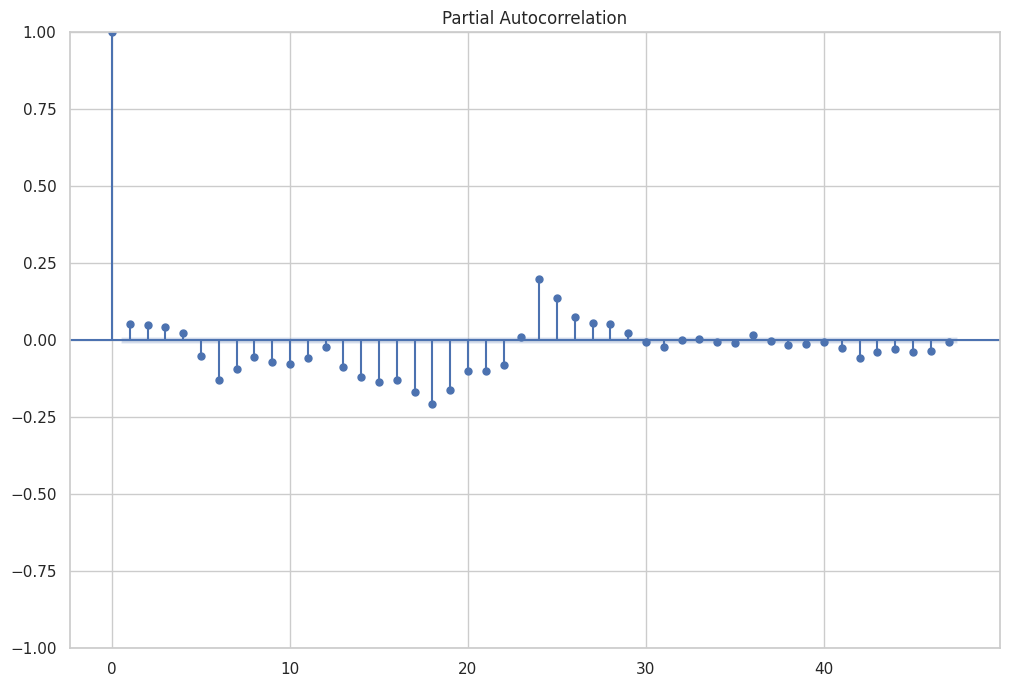

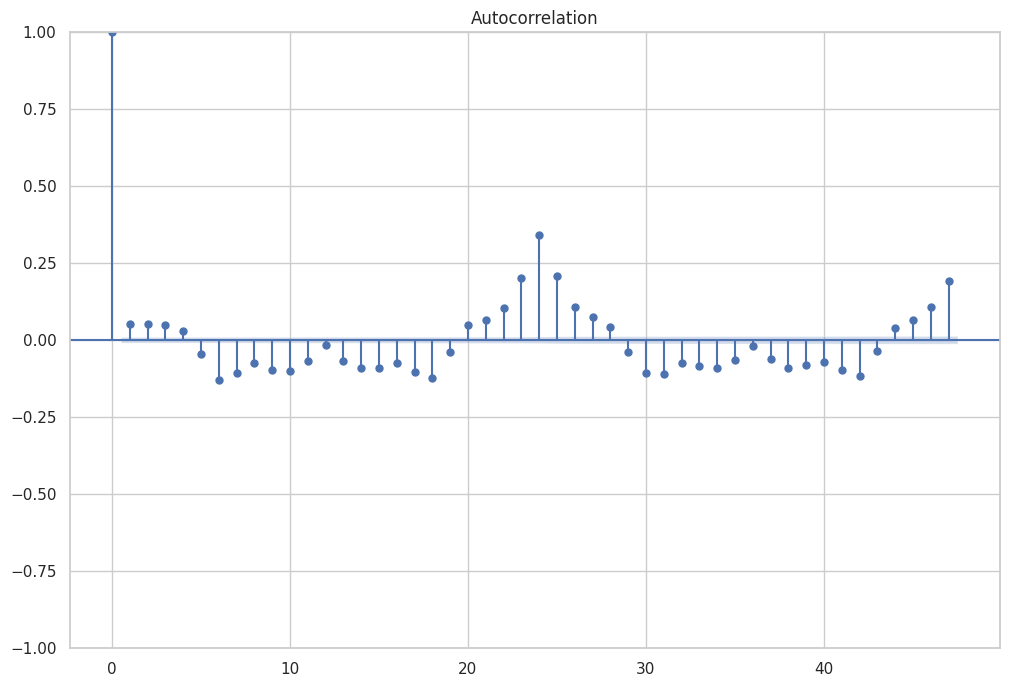

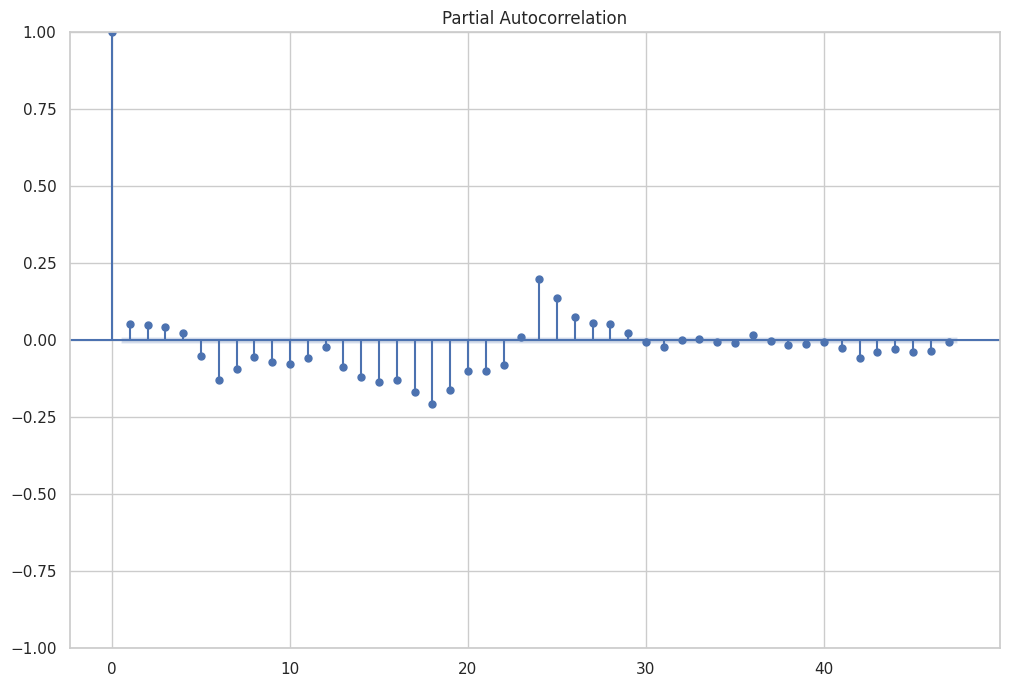

In [110]:
plot_acf(traffic_data['Vehicles_diff'].dropna())
plot_pacf(traffic_data['Vehicles_diff'].dropna())

In [123]:
#Pivoting data from junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.head()

Vehicles                            Year                  \
Junction                    1         2         3   4       1       2       3   
DateTime                                                                        
2015-11-01 00:00:00 -0.375485 -0.809218 -0.664641 NaN  2015.0  2015.0  2015.0   
2015-11-01 01:00:00 -0.471870 -0.809218 -0.761026 NaN  2015.0  2015.0  2015.0   
2015-11-01 02:00:00 -0.616448 -0.857411 -0.857411 NaN  2015.0  2015.0  2015.0   
2015-11-01 03:00:00 -0.761026 -0.809218 -1.050182 NaN  2015.0  2015.0  2015.0   
2015-11-01 04:00:00 -0.664641 -0.761026 -1.001989 NaN  2015.0  2015.0  2015.0   

                        Month                 Date_no               Hour       \
Junction              4     1     2     3   4       1    2    3   4    1    2   
DateTime                                                                        
2015-11-01 00:00:00 NaN  11.0  11.0  11.0 NaN     1.0  1.0  1.0 NaN  0.0  0.0   
2015-11-01 01:00:00 NaN  11.0  11.0  11.0 NaN     1.0  1.0  1.0 NaN  1.0  1.0   
2015-11-01 02:00:00 NaN  11.0  11.0  11.0 NaN     1.0  1.0  1.0 NaN  2.0  2.0   
2015-11-01 03:00:00 NaN  11.0  11.0  11.0 NaN     1.0  1.0  1.0 NaN  3.0  3.0   
2015-11-01 04:00:00 NaN  11.0  11.0  11.0 NaN     1.0  1.0  1.0 NaN  4.0  4.0   

                              
Junction               3   4  
DateTime                      
2015-11-01 00:00:00  0.0 NaN  
2015-11-01 01:00:00  1.0 NaN  
2015-11-01 02:00:00  2.0 NaN  
2015-11-01 03:00:00  3.0 NaN  
2015-11-01 04:00:00  4.0 NaN

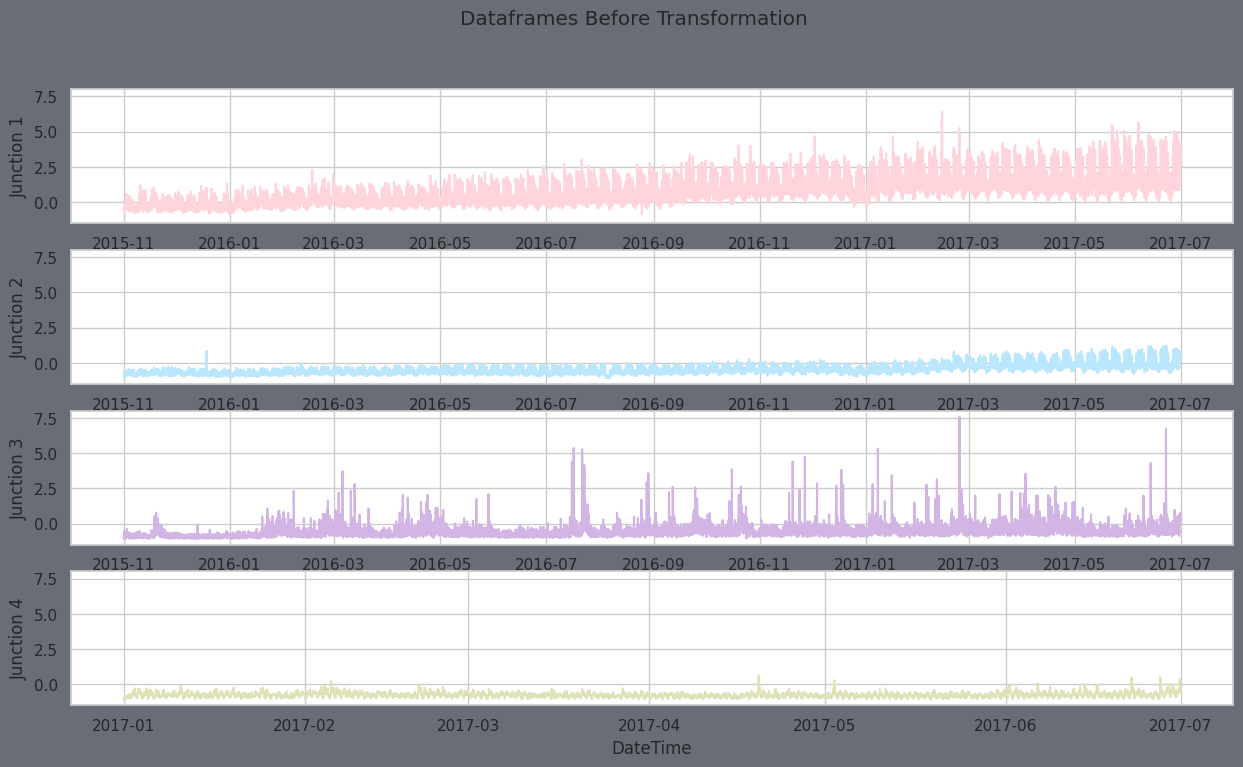

In [124]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#686D76", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [125]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [126]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

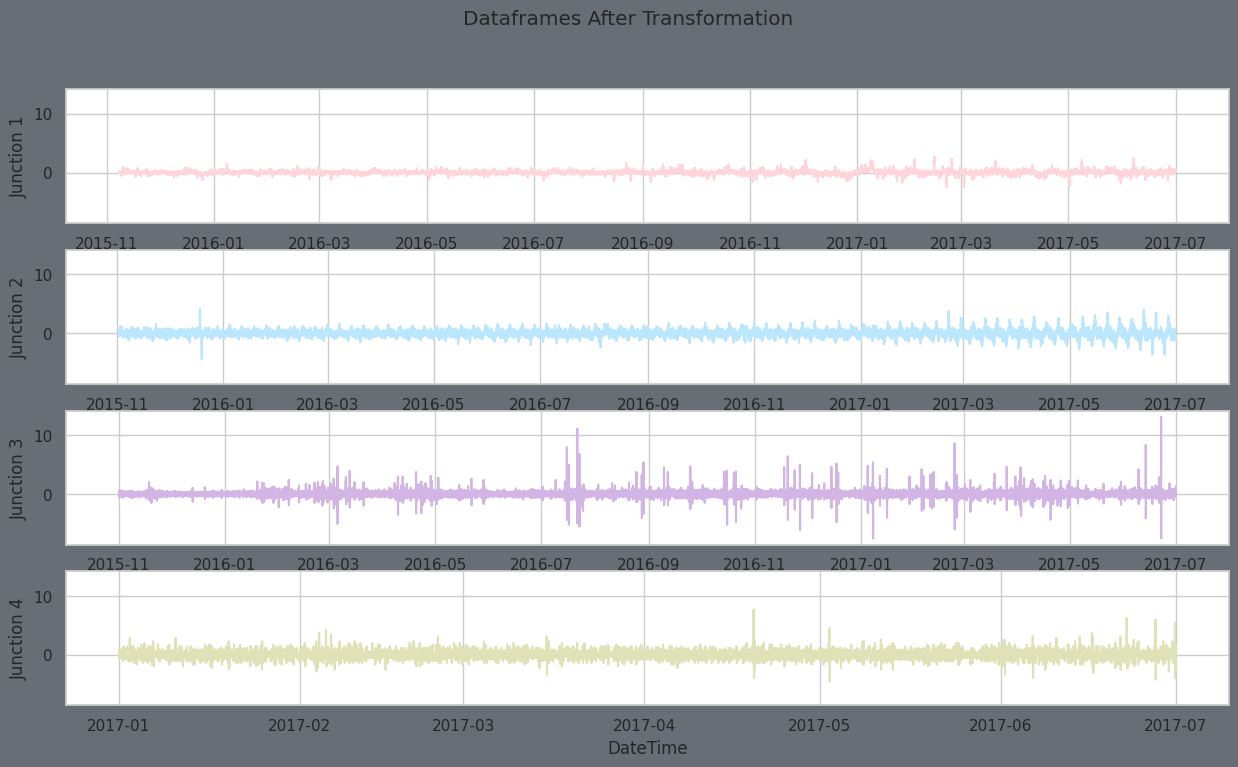

In [127]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [128]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.26530339041554
p-value: 4.7985398763952365e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940094
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832668
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052173
p-value: 2.778787532595739e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [129]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [130]:
X_trainJ1.shape

(12949, 32, 1)

In [131]:
# Custom Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [132]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)


In [133]:
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

In [134]:
#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#686D76")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [135]:
# Predictions For First Junction
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

########------LSTM Model------########
Epoch 1/50
108/108 [==============================] - 16s 113ms/step - loss: 0.0658 - val_loss: 0.0834
Epoch 2/50
108/108 [==============================] - 11s 103ms/step - loss: 0.0591 - val_loss: 0.0791
Epoch 3/50
108/108 [==============================] - 11s 102ms/step - loss: 0.0574 - val_loss: 0.0755
Epoch 4/50
108/108 [==============================] - 10s 88ms/step - loss: 0.0562 - val_loss: 0.0735
Epoch 5/50
108/108 [==============================] - 11s 103ms/step - loss: 0.0549 - val_loss: 0.0714
Epoch 6/50
108/108 [==============================] - 11s 105ms/step - loss: 0.0540 - val_loss: 0.0711
Epoch 7/50
108/108 [==============================] - 11s 104ms/step - loss: 0.0531 - val_loss: 0.0681
Epoch 8/50
108/108 [==============================] - 9s 88ms/step - loss: 0.0520 - val_loss: 0.0672
Epoch 9/50
108/108 [==============================] - 11s 103ms/step - loss: 0.0516 - val_loss: 0.0662
Epoch 10/50
108/108 [================


########------LSTM Model------########
The root mean squared error is 0.24300871951849315.


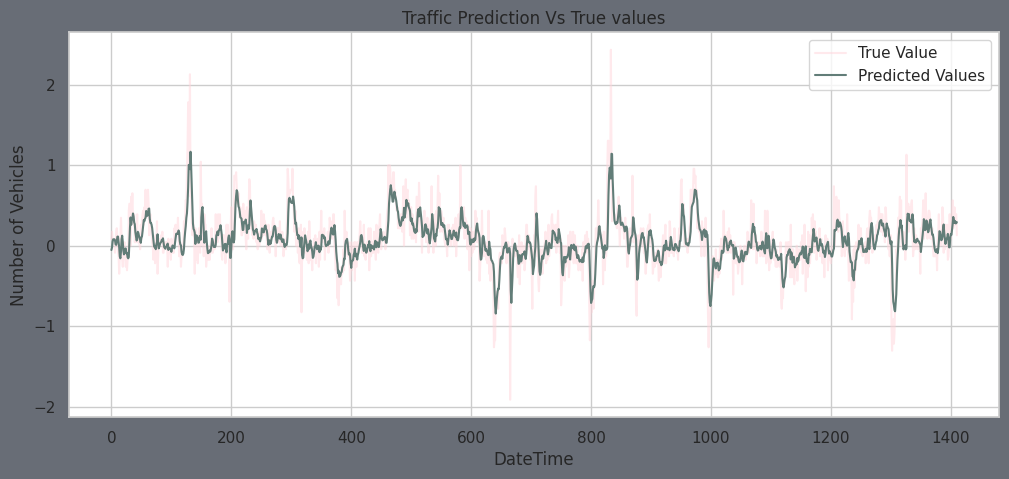

In [136]:
# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)


In [137]:
# Predictions For Second Junction
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

########------LSTM Model------########
Epoch 1/50
109/109 [==============================] - 16s 97ms/step - loss: 0.2169 - val_loss: 0.4055
Epoch 2/50
109/109 [==============================] - 11s 103ms/step - loss: 0.1916 - val_loss: 0.3692
Epoch 3/50
109/109 [==============================] - 11s 103ms/step - loss: 0.1887 - val_loss: 0.3565
Epoch 4/50
109/109 [==============================] - 11s 104ms/step - loss: 0.1863 - val_loss: 0.3434
Epoch 5/50
109/109 [==============================] - 11s 103ms/step - loss: 0.1866 - val_loss: 0.3368
Epoch 6/50
109/109 [==============================] - 10s 91ms/step - loss: 0.1840 - val_loss: 0.3287
Epoch 7/50
109/109 [==============================] - 11s 103ms/step - loss: 0.1833 - val_loss: 0.3348
Epoch 8/50
109/109 [==============================] - 11s 103ms/step - loss: 0.1838 - val_loss: 0.3231
Epoch 9/50
109/109 [==============================] - 13s 118ms/step - loss: 0.1823 - val_loss: 0.3259
Epoch 10/50
109/109 [===============


########------LSTM Model------########
The root mean squared error is 0.5483555060974208.


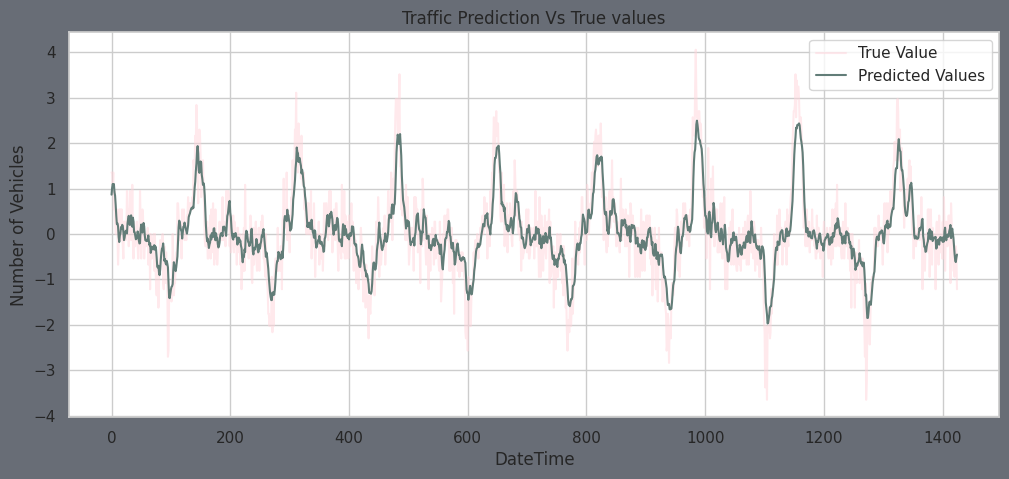

In [138]:
# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)